In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import fft
from tqdm.auto import tqdm

# from nalger_helper_functions import conforming_grid_convolution, conforming_box, make_regular_grid, plot_rectangle
from nalger_helper_functions import *

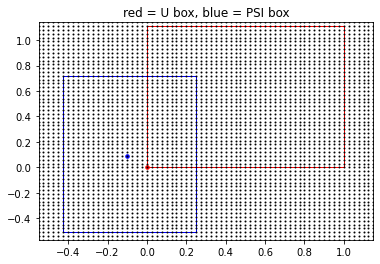

In [2]:
hh = np.array([0.025, 0.03]) * 1.0

U_centerpoint = np.zeros(2)
min_U, max_U, U_shape = conforming_box(np.array([0., 0.]), np.array([1., 1.1]), U_centerpoint, hh)

PSI_centerpoint = np.round(np.array([-0.1, 0.1]) / hh) * hh
min_PSI, max_PSI, PSI_shape = conforming_box(np.array([-0.4, -0.5]), np.array([0.23, 0.7]), PSI_centerpoint, hh)
# min_PSI, max_PSI, PSI_shape = conforming_box(np.array([-0.3, -0.2]), np.array([0.05, 0.3]), PSI_centerpoint, hh)
# min_PSI, max_PSI, PSI_shape = conforming_box(np.array([-1.7, -1.9]), np.array([1.4, 2.0]), PSI_centerpoint, hh)

min_plot, max_plot, plot_shape = conforming_box(np.min([min_U, min_PSI])-hh, np.max([max_U, max_PSI])+hh, 
                                                np.zeros(2), hh)

d = len(min_PSI)

_, (XPSI, YPSI) = make_regular_grid(min_PSI, max_PSI, PSI_shape)
_, (XU, YU) = make_regular_grid(min_U, max_U, U_shape)
_, (X, Y) = make_regular_grid(min_plot, max_plot, plot_shape)

plt.figure()

r1 = plot_rectangle(min_U, max_U, edgecolor='r')
plt.plot(U_centerpoint[0], U_centerpoint[1], '.r', markersize=7)

r2 = plot_rectangle(min_PSI, max_PSI, edgecolor='b')
plt.plot(PSI_centerpoint[0], PSI_centerpoint[1], '.b', markersize=7)

plt.plot(X[:], Y[:], '.k', markersize=2)

plt.xlim(min_plot[0], max_plot[0])
plt.ylim(min_plot[1], max_plot[1])

plt.title('red = U box, blue = PSI box')

plt.show()

In [3]:
def make_2D_grid_gaussian(mu, Sigma, X, Y):
    d = len(X.shape)
    C = np.power(2 * np.pi, -d/2.) * np.power(np.linalg.det(Sigma), -1./2.)
    
    zz = np.vstack([X.reshape(-1), Y.reshape(-1)]) - mu.reshape((-1,1))
    F = C * np.exp(-0.5 * np.sum(zz * np.linalg.solve(Sigma, zz), axis=0).reshape(-1)).reshape(X.shape)
    return F

$$H \delta_{x_i} = \psi_i$$

$$H^{1/2} \delta_{x_i} \approx z_i$$

$$H u \approx \sum_i (H\delta_{x_i}) \ast (w_i \cdot u) = \sum_i \psi_i \ast (w_i \cdot u)$$

$$H^{1/2} u \approx \sum_i (H^{1/2}\delta_{x_i}) \ast (w_i \cdot u) \approx \sum_i z_i \ast (w_i \cdot u)$$

If $Tu := \psi \ast u$ then $T^{1/2}u := z \ast u$

Let $H$ be a locally translation invariant operator. Then
$$H u \approx \sum_i (H\delta_{x_i}) \ast (w_i \cdot u)$$

$$PC = \sum_{i=1}^r z_i \ast (w_i \cdot u)$$

$$PC^H = \sum_{i=1}^r  w_i \cdot (\text{flip}(\bar{z_i}) \ast u)$$

$$Au := z \ast u$$

$$A = A^H$$

$$PC = H^{1/2} + E$$

$$PC^H PC = {H^{1/2}}^H H^{1/2} + {H^{1/2}}^H E + E H^{1/2} + E E = H + O(E)$$

nonsymmetry= 0.5019862009620989


/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:161: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.data)


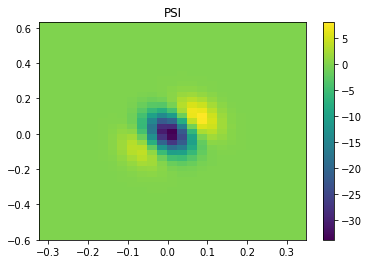

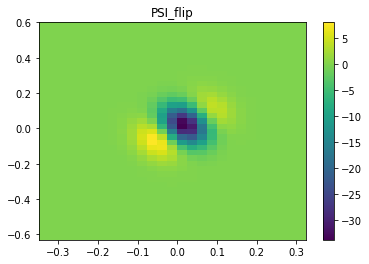

In [4]:
mu = PSI_centerpoint
Sigma = np.array([[0.004, 0.0015], 
                  [0.0015, 0.011]])*0.7

# PSI_data = make_2D_grid_gaussian(mu, Sigma, XPSI, YPSI)
PSI_data = make_2D_grid_gaussian(mu, Sigma, XPSI, YPSI) * np.sin(20*XPSI + 8*YPSI) * 1.

PSI = BoxFunction(min_PSI, max_PSI, PSI_data).translate(-PSI_centerpoint)
# PSI = -PSI

# PSI = (PSI + PSI.flip()) / 2. # make symmetric

nonsymmetry = (PSI - PSI.flip()).norm() / PSI.norm()
print('nonsymmetry=', nonsymmetry)

PSI_width0 = PSI.box_max - PSI.box_min 

# PSI = PSI.restrict_to_another_box(PSI.box_min - PSI_width0, PSI.box_max + PSI_width0)
# PSI = PSI.restrict_to_another_box(PSI.box_min, PSI.box_max + PSI_width0)

PSI_flip = PSI.flip()

PSI.plot(title='PSI')
PSI_flip.plot(title='PSI_flip')

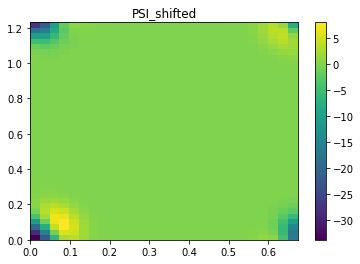

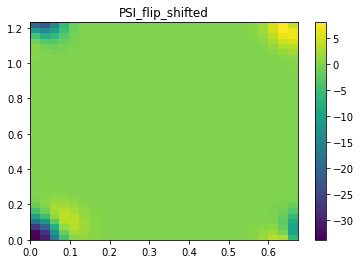

In [5]:
PSI_shifted_data = np.roll(PSI.data, -PSI.zeropoint_index, axis=np.arange(PSI.ndim))
PSI_shifted = BoxFunction(np.zeros(2), PSI.box_max - PSI.box_min, PSI_shifted_data)

PSI_shifted.plot(title='PSI_shifted')

PSI_flip_shifted_data = np.roll(PSI.flip().data, -PSI_flip.zeropoint_index, axis=np.arange(PSI_flip.ndim))
PSI_flip_shifted = BoxFunction(np.zeros(2), PSI_flip.box_max - PSI_flip.box_min, PSI_flip_shifted_data)

PSI_flip_shifted.plot(title='PSI_flip_shifted')

2.6607586775080574e-14

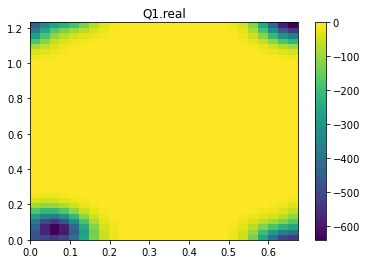

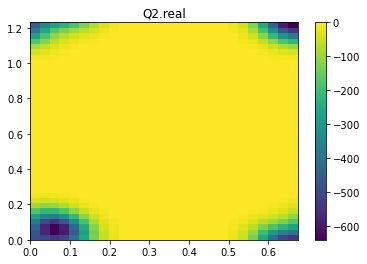

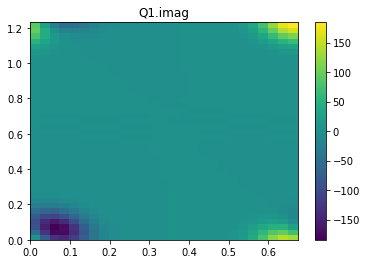

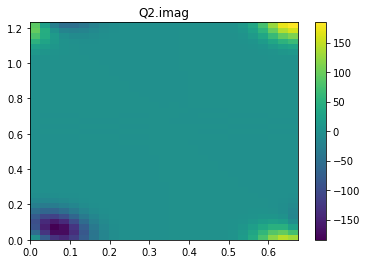

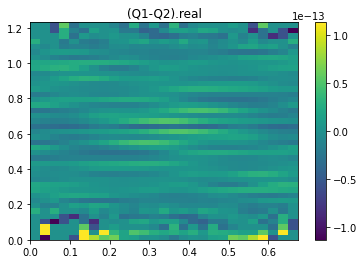

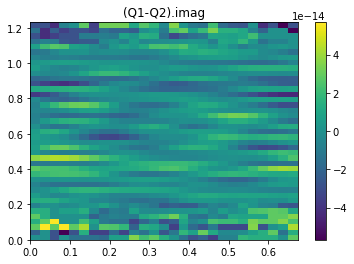

In [6]:
Q1 = BoxFunction(np.zeros(2), PSI.box_max - PSI.box_min, fft.fftn(PSI_shifted.data))
Q2 = BoxFunction(np.zeros(2), PSI_flip.box_max - PSI_flip.box_min, fft.fftn(PSI_flip_shifted.data).conj())

Q1.real.plot(title='Q1.real')
Q2.real.plot(title='Q2.real')

Q1.imag.plot(title='Q1.imag')
Q2.imag.plot(title='Q2.imag')

(Q1-Q2).real.plot(title='(Q1-Q2).real')
(Q1-Q2).imag.plot(title='(Q1-Q2).imag')

(Q1 - Q2).norm()

<ipython-input-7-8f43dbb6b217>:2: RuntimeWarning: invalid value encountered in sqrt
  Q1_angle_sqrt.data = np.sqrt(Q1_angle_sqrt.data)


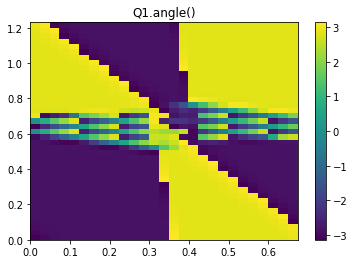

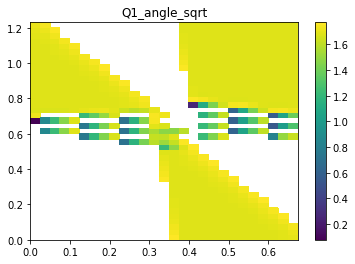

In [7]:
Q1_angle_sqrt = Q1.angle().copy()
Q1_angle_sqrt.data = np.sqrt(Q1_angle_sqrt.data)

Q1.angle().plot('Q1.angle()')
Q1_angle_sqrt.plot('Q1_angle_sqrt')

In [8]:
def square_root(z, branch_cut_theta):
    "Square root with different branch cut defined by theta parameter."
    #https://flothesof.github.io/branch-cuts-with-square-roots.html
    argument = np.angle(z) # between -pi and +pi
    modulus = np.abs(z)
#     argument = np.mod(argument + branch_cut_theta, 2 * np.pi) - branch_cut_theta
    argument[z.real>0] = np.mod(argument[z.real>0] + np.pi, 2 * np.pi) - np.pi
    argument[z.real<=0] = np.mod(argument[z.real<=0], 2 * np.pi)
    
#     Q1 = np.logical_and(z.real >= 0, z.imag >= 0)
#     Q2 = np.logical_and(z.real < 0, z.imag >= 0)
#     Q3 = np.logical_and(z.real < 0, z.imag < 0)
#     Q4 = np.logical_and(z.real >= 0, z.imag < 0)
# #     IM = (z.imag == 0)

#     angle_0_2pi = np.mod(argument, 2 * np.pi)
    
#     argument[Q1] = angle_0_2pi[Q1] / 2.
#     argument[Q4] = -(2*np.pi - angle_0_2pi[Q4]) / 2.
    
#     argument[Q2] = angle_0_2pi[Q2] / 2.
#     argument[Q3] = -(2*np.pi - angle_0_2pi[Q3]) / 2.
# #     argument[IM] = 
    
    return np.sqrt(modulus) * np.exp(1j * argument / 2)

imag_fraction= 0.9999999999998538


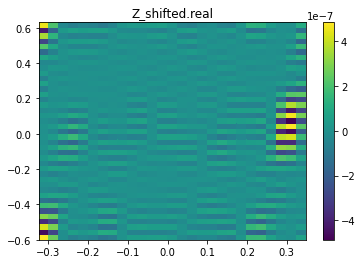

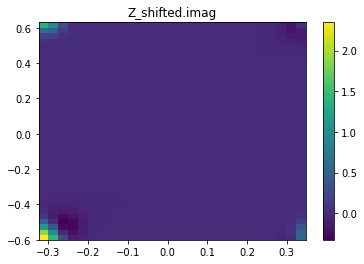

In [9]:
Z_shifted_data = fft.ifftn(square_root(fft.fftn(PSI_shifted.data), 1.0*np.pi))
imag_fraction = np.linalg.norm(Z_shifted_data.imag) / np.linalg.norm(Z_shifted_data)
print('imag_fraction=', imag_fraction)

Z_shifted = BoxFunction(PSI.box_min, PSI.box_max, Z_shifted_data)

Z_shifted.real.plot('Z_shifted.real')
Z_shifted.imag.plot('Z_shifted.imag')

Z.real.norm()= 3.196243876758822e-06
Z.imag.norm()= 5.902374029031138


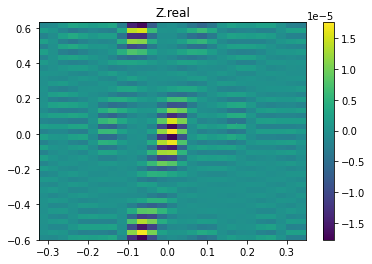

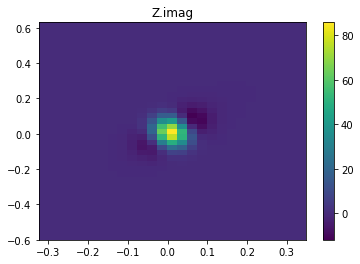

In [10]:
Z_data = np.roll(Z_shifted.data, PSI.zeropoint_index, axis=np.arange(Z_shifted.ndim))

Z = BoxFunction(Z_shifted.box_min, Z_shifted.box_max, Z_data) * (1./np.sqrt(Z_shifted.element_volume))

Z.real.plot(title='Z.real')
Z.imag.plot(title='Z.imag')

Z_real_norm = Z.real.norm()
print('Z.real.norm()=', Z.real.norm())

Z_imag_norm = Z.imag.norm()
print('Z.imag.norm()=', Z.imag.norm())

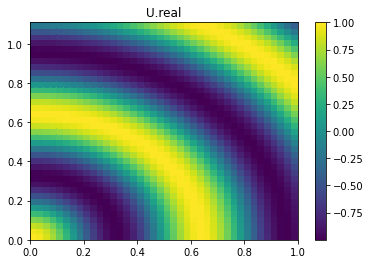

In [11]:
U_data = np.cos(10*np.sqrt(XU**2 + YU**2))

U = BoxFunction(min_U, max_U, U_data).translate(-U_centerpoint).astype('complex')
# U = U.restrict_to_another_box(U.box_min - U.hh, U.box_max + 2*U.hh)

U.real.plot(title='U.real')

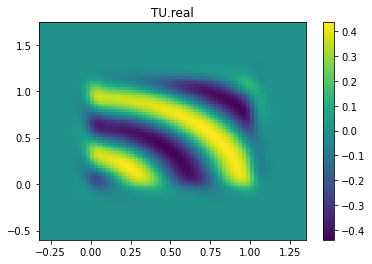

In [12]:
TU = convolve_box_functions(PSI, U)

TU.real.plot(title='TU.real')

In [13]:
def convolve_with_Z(x):
    X = BoxFunction(U.box_min, U.box_max, x.reshape(U.shape))
    Y = convolve_box_functions(Z, X).restrict_to_another_box(U.box_min, U.box_max)
    return Y.data.reshape(-1)

n = np.prod(U.shape)
T = np.zeros((n,n), dtype='complex')
for k in tqdm(range(n)):
    ek = np.zeros(n, dtype='complex')
    ek[k] = 1.
    T[:,k] = convolve_with_Z(ek)

Z_star = Z.flip().conj()
def convolve_with_Z_star(x):
    X = BoxFunction(U.box_min, U.box_max, x.reshape(U.shape))
    Y = convolve_box_functions(Z_star, X).restrict_to_another_box(U.box_min, U.box_max)
    return Y.data.reshape(-1)

T_star = np.zeros((n,n), dtype='complex')
for k in tqdm(range(n)):
    ek = np.zeros(n, dtype='complex')
    ek[k] = 1.
    T_star[:,k] = convolve_with_Z_star(ek)
    
def convolve_with_PSI(x):
    X = BoxFunction(U.box_min, U.box_max, x.reshape(U.shape))
    Y = convolve_box_functions(PSI, X).restrict_to_another_box(U.box_min, U.box_max)
    return Y.data.reshape(-1)

H = np.zeros((n,n), dtype='complex')
for k in tqdm(range(n)):
    ek = np.zeros(n, dtype='complex')
    ek[k] = 1.
    H[:,k] = convolve_with_PSI(ek)

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

In [14]:
np.linalg.norm(T.T.conj() - T_star) / np.linalg.norm(T)

1.8420790848982956e-14

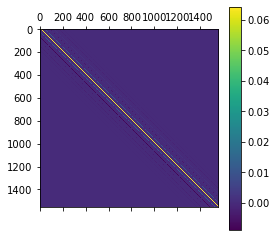

In [15]:
plt.matshow(T.imag)
plt.colorbar()

In [16]:
T_star_T = T_star @ T
ee1 , P1 = np.linalg.eig(T_star_T)

In [17]:
TT = T @ T
ee2 , P2 = np.linalg.eig(TT)

In [18]:
ee3 , P3 = np.linalg.eig((H + H.T)/2.)

In [19]:
np.linalg.norm(ee3.imag)

3.183177832738915e-16

In [20]:
np.linalg.norm(TT - H) / np.linalg.norm(H)

0.06442920070021126

In [36]:
np.linalg.norm(T_star_T + (H+H.T)/2.) / np.linalg.norm(H)

0.06455714369735405

In [22]:
np.linalg.norm(ee1.imag)

2.300208836548268e-16

In [23]:
np.min(np.sort(ee1.real))

-2.8828879928690984e-18

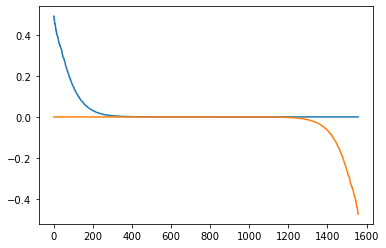

In [24]:
plt.plot(np.sort(ee1.real)[::-1])
plt.plot(np.sort(ee3.real)[::-1])

In [25]:
ee, P = np.linalg.eig(T)

In [26]:
np.max(np.abs(ee.real))

0.09638686262901486

In [27]:
np.max(np.abs(T))

0.06429733474384111

In [28]:
Z.element_volume - Z.flip().element_volume

0.0

/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:161: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.data)


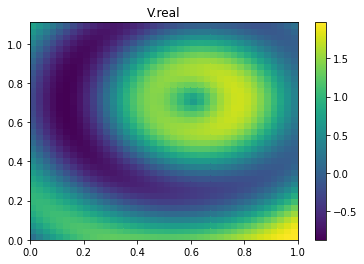

In [29]:
V_data = np.sin(10*np.sqrt((XU-0.6)**2 + (YU - 0.7)**2)) + XU

V = BoxFunction(min_U, max_U, V_data).translate(-U_centerpoint).astype('complex')
# V = V.restrict_to_another_box(V.box_min - V.hh, V.box_max + 2*V.hh)

V.real.plot(title='V.real')

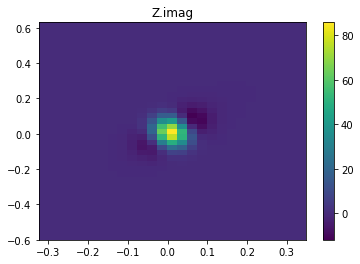

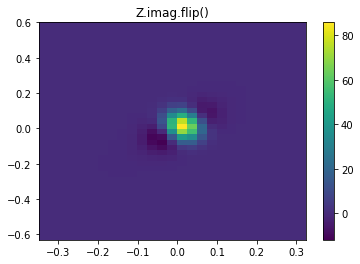

In [30]:
Z.imag.plot(title='Z.imag')
Z.imag.flip().plot(title='Z.imag.flip()')

In [31]:
(convolve_box_functions(V.real, Z.imag.flip()) - convolve_box_functions(Z.imag.flip(), V.real)).norm()

8.557103567482263e-17

In [32]:
ip1 = convolve_box_functions(Z, U).inner(V)
ip2 = U.inner(convolve_box_functions(Z.flip().conj(), V))
err_adj = np.abs((ip1 - ip2) / ip1)
print('err_adj=', err_adj)

err_adj= 9.122547946686303e-15


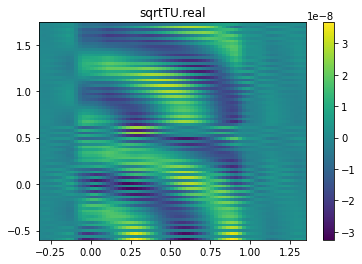

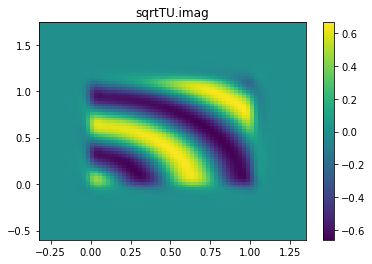

In [33]:
sqrtTU = convolve_box_functions(Z, U)

sqrtTU.real.plot('sqrtTU.real')
sqrtTU.imag.plot('sqrtTU.imag')

In [34]:
# Z_star = BoxFunction(-Z.box_max, -Z.box_min, Z.data[::-1,::-1].conj())
Z_star = Z.flip().conj()

err_sqrt= 3.275458692634529e-05


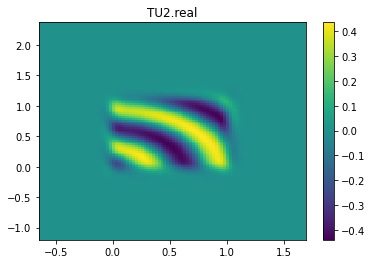

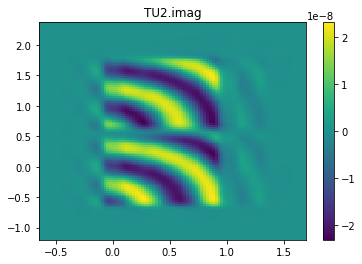

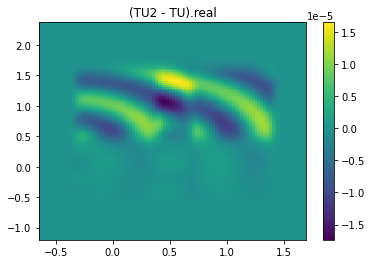

In [35]:
TU2 = convolve_box_functions(Z, sqrtTU)
# TU2 = -convolve_box_functions(Z.flip().conj(), sqrtTU)
# TU2 = convolve_box_functions(Z, sqrtTU)

TU2.real.plot('TU2.real')
TU2.imag.plot('TU2.imag')

ERR = (TU2 - TU)
# ERR = ERR.restrict_to_another_box(U.box_min, U.box_max)

err_sqrt = ERR.norm() / TU.norm()
print('err_sqrt=', err_sqrt)

ERR.real.plot(title='(TU2 - TU).real')